### 导包

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

### 设定需求省份

#### 设置变量state_name的值，即我们需要进行模型求解的省份名（注意拼音首字母大写）

In [2]:
state_name = 'Beijing'

#### 由关系式$$\lambda = k_{t-1}e^{\gamma(R_t-1)}$$ 给出未知变量的值。

In [3]:
# 我们为Rt的每个可能值创建一个数组
R_T_MAX = 6
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# 伽玛为1 /序列间隔
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

### 构建处理数据需要用到的自定义函数

#### 函数**prepare_cases**，计算每日新增病例数以及每日新增病例经移动窗口函数处理后的结果。

In [4]:
def prepare_cases(cases):
    # 差分，计算出每日的新增病例
    new_cases = cases.diff()
    
    # 移动窗口函数处理差分后的数据，使得原数据更加准确。
    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    # original差分后的原始数据
    original = new_cases
    
    return original, smoothed

#### 函数**get_posteriors**，求得Rt随时间变化得后验。

In [5]:
def get_posteriors(sr, sigma=0.15):

    # (1) 计算 Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) 计算每天的可能性
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) 创建高斯矩阵
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) 将所有行归一化为1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) 计算初始先验
#     prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # 创建一个DataFrame，将每天保存我们的后代
    # 插入我们的先验作为第一后验。
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # 我们说过，为了最大似然计算，我们将跟踪数据概率的对数之和
    log_likelihood = 0.0

    # (5) 反复应用贝叶斯规则
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) 计算新的先验
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) 计算贝叶斯规则的分子: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) 计算贝叶斯法则的分母 P(k)
        denominator = np.sum(numerator)
        
        # 执行完整的贝叶斯规则
        posteriors[current_day] = numerator/denominator
        
        # 加上对数似然的连续总和
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

#### 函数**highest_density_interval**,求出目标省份的HDI。

In [6]:
def highest_density_interval(pmf, p=.9, debug=False):
    # 如果我们传递一个DataFrame，只需在列上递归调用
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # 每个低，高的总概率质量的N x N矩阵
    total_p = cumsum - cumsum[:, None]
    
    # 返回total_p> p的所有索引
    lows, highs = (total_p > p).nonzero()
    
    # 找到最小范围（最高密度）
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

### 数据处理步骤

####  导入整个中国所有省份的疫情数据(注意这里只包含了30个省的数据，西藏、澳门、台湾、)

In [7]:
# 导入数据
states = pd.read_csv('dailyofcopy.csv',
                     usecols=['date', 'state', 'positive'],
                     parse_dates=['date'],
                     index_col=['state', 'date'],
                     squeeze=True).sort_index()

# 查看有哪些省份的数据，并打印出省份名
state_names = pd.DataFrame(states).unstack().index
state_names

Index(['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hong Kong', 'Hubei', 'Hunan', 'Inner Mongolia', 'Jiangsu', 'Jiangxi',
       'Jilin', 'Liaoning', 'Ningxia', 'Shaanxi', 'Shandong', 'Shanghai',
       'Shanxi', 'Sichuan', 'Tianjin', 'Xinjiang', 'Yunnan', 'Zhejiang'],
      dtype='object', name='state')

#### 可视化数据，画出目标省份（或者每个省份）的新增病例随时间的变化趋势，代码分别在下方，根据需求选择。

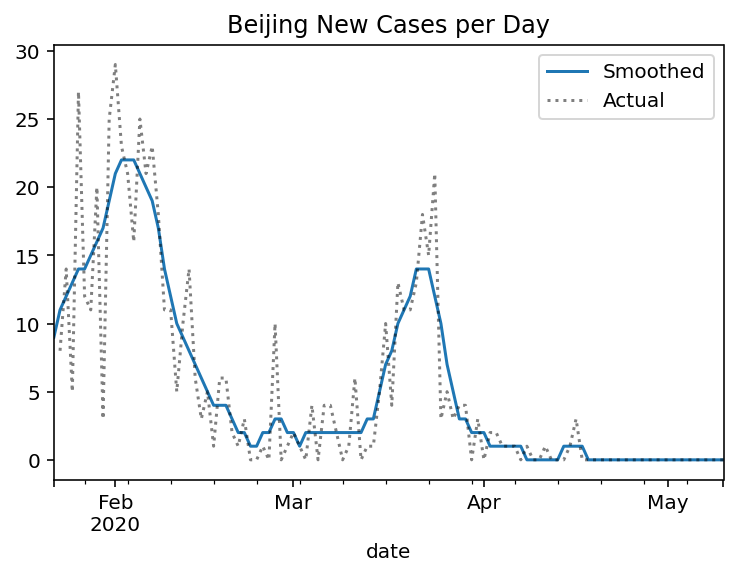

In [8]:
# # 所有省份新增病例随时间变化
# fig = plt.figure(figsize=(22,18))
# fig.subplots_adjust(hspace=0.6, wspace=0.4)
# # a = []
# for x in range(len(state_names)): 
#     cases = states.xs(state_names[x]).rename(f"{state_names[x]} cases")
#     original, smoothed = prepare_cases(cases)
#     posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)
#     most_likely_values = posteriors.idxmax()
# #     a.append(most_likely_values)

#     if x ==1:
#         most_likely_values = pd.DataFrame(most_likely_values)
#         most_likely_values.columns
#     else:
#         most_likely_values[state_names[x]] = most_likely_values
#     ax = fig.add_subplot(10, 3, x+1)
#     ax = smoothed.plot(label='Smoothed',
#                    legend=True)
#     original.plot(title=f"{state_names[x]} New Cases per Day",
#                c='k',
#                linestyle=':',
#                alpha=.5,
#                label='Actual',
#                legend=True)

# 目标省份新增病例随时间变化
cases = states.xs(state_name).rename(f"{state_name} cases")
original, smoothed = prepare_cases(cases)
ax = smoothed.plot(label='Smoothed',
                   legend=True)
original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True)

#### 导出每个省Rt值随时间变化的值

In [9]:
# # 导出每个省Rt值随时间变化的值
# b = pd.DataFrame(a)
# b.index = state_names
# b.T.fillna(0).to_csv('./data999.csv')

#### 求出目标省份每天的Rt的变化趋势（未进行贝叶斯更新），并可视化。

d:\pyton3.7\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log


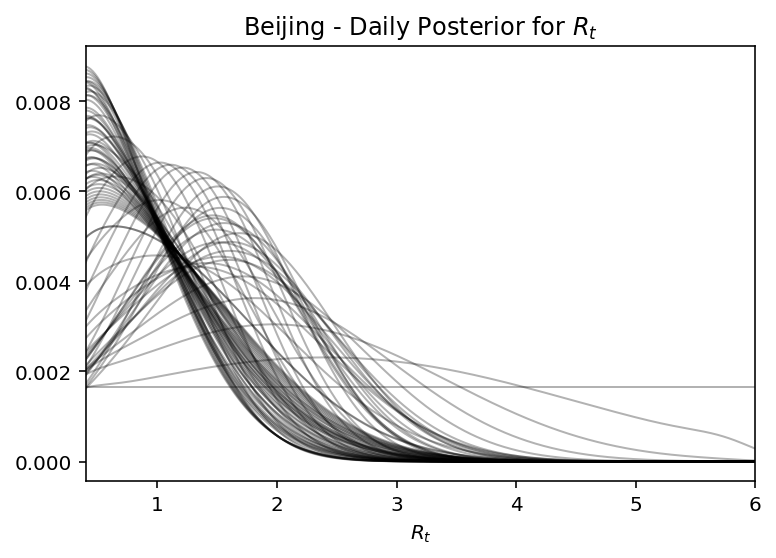

In [10]:
# 请注意，仅在示例中，我们将sigma固定为一个值
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');

#### 求**HDI**（贝叶斯估计关于Rt的最高密度区间）并可视化。

In [11]:
# 请注意，这需要一段时间才能执行-这不是最有效的算法
# 求HDI
# hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# 探究为什么要移-1
# result = pd.concat([most_likely, hdis], axis=1)

result = pd.DataFrame(most_likely)
result['ML'] .values

array([0.  , 2.4 , 1.97, 1.81, 1.72, 1.53, 1.51, 1.49, 1.47, 1.53, 1.56,
       1.51, 1.41, 1.33, 1.21, 1.11, 1.02, 0.87, 0.63, 0.51, 0.44, 0.43,
       0.42, 0.41, 0.4 , 0.39, 0.38, 0.41, 0.42, 0.4 , 0.39, 0.4 , 0.39,
       0.4 , 0.45, 0.46, 0.52, 0.53, 0.47, 0.48, 0.44, 0.5 , 0.5 , 0.51,
       0.51, 0.52, 0.52, 0.53, 0.53, 0.53, 0.54, 0.64, 0.64, 0.99, 1.32,
       1.41, 1.6 , 1.61, 1.6 , 1.68, 1.56, 1.46, 1.23, 1.02, 0.65, 0.47,
       0.4 , 0.42, 0.4 , 0.42, 0.44, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46,
       0.42, 0.43, 0.44, 0.45, 0.46, 0.46,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

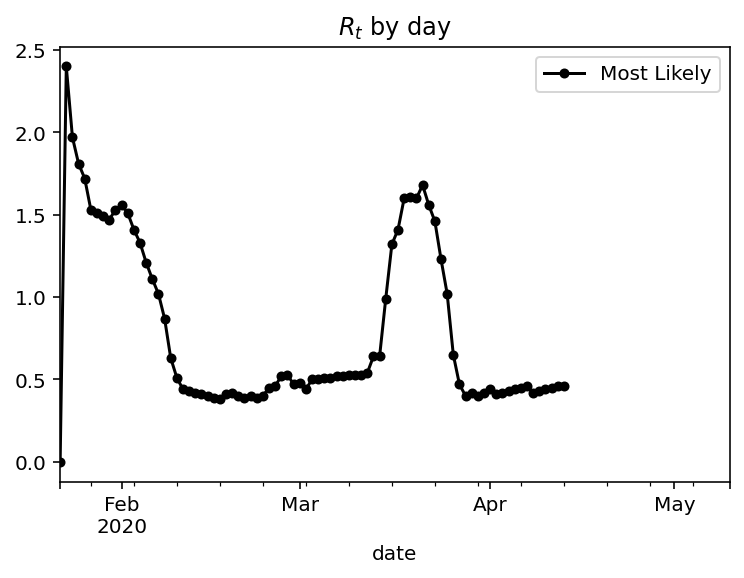

In [12]:
ax = most_likely.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

# ax.fill_between(hdis.index,
#                 hdis['Low_90'],
#                 hdis['High_90'],
#                 color='k',
#                 alpha=.1,
#                 lw=0,
#                 label='HDI')

ax.legend();

#### 自定义函数**plot_rt**并调用，可视化实际时间的Rt值随时间的变化

In [13]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # 颜色
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
#     # 绘制点和线
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
#     # 从美学上讲，每边1天推算可信区间
#     lowfn = interp1d(date2num(index),
#                      result['Low_90'].values,
#                      bounds_error=False,
#                      fill_value='extrapolate')
    
#     highfn = interp1d(date2num(index),
#                       result['High_90'].values,
#                       bounds_error=False,
#                       fill_value='extrapolate')
    
#     extended = pd.date_range(start=pd.Timestamp('2020-01-23'),
#                              end=index[-1]+pd.Timedelta(days=1))
    
#     ax.fill_between(extended,
#                     lowfn(date2num(extended)),
#                     highfn(date2num(extended)),
#                     color='k',
#                     alpha=.1,
#                     lw=0,
#                     zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
#    格式化
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 3)
    ax.set_xlim(pd.Timestamp('2020-01-23'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

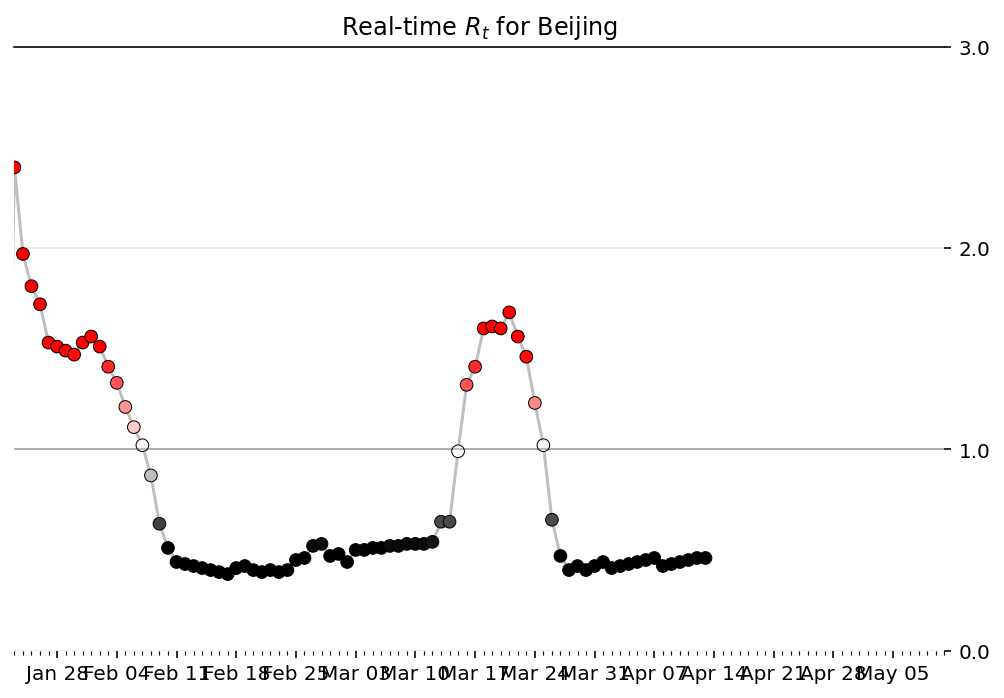

In [14]:
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))